In [1]:
import gensim
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

# 60

In [3]:
model['United_States']

array([-3.61328125e-02, -4.83398438e-02,  2.35351562e-01,  1.74804688e-01,
       -1.46484375e-01, -7.42187500e-02, -1.01562500e-01, -7.71484375e-02,
        1.09375000e-01, -5.71289062e-02, -1.48437500e-01, -6.00585938e-02,
        1.74804688e-01, -7.71484375e-02,  2.58789062e-02, -7.66601562e-02,
       -3.80859375e-02,  1.35742188e-01,  3.75976562e-02, -4.19921875e-02,
       -3.56445312e-02,  5.34667969e-02,  3.68118286e-04, -1.66992188e-01,
       -1.17187500e-01,  1.41601562e-01, -1.69921875e-01, -6.49414062e-02,
       -1.66992188e-01,  1.00585938e-01,  1.15722656e-01, -2.18750000e-01,
       -9.86328125e-02, -2.56347656e-02,  1.23046875e-01, -3.54003906e-02,
       -1.58203125e-01, -1.60156250e-01,  2.94189453e-02,  8.15429688e-02,
        6.88476562e-02,  1.87500000e-01,  6.49414062e-02,  1.15234375e-01,
       -2.27050781e-02,  3.32031250e-01, -3.27148438e-02,  1.77734375e-01,
       -2.08007812e-01,  4.54101562e-02, -1.23901367e-02,  1.19628906e-01,
        7.44628906e-03, -

# 61

In [4]:
model.cosine_similarities(model['United_States'], model['U.S.'].reshape(1, -1))

array([0.7310775], dtype=float32)

# 62

In [5]:
model.most_similar('United_States', topn=10)

[('Unites_States', 0.7877248525619507),
 ('Untied_States', 0.7541370391845703),
 ('United_Sates', 0.74007248878479),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404393911361694),
 ('America', 0.6178410053253174),
 ('UnitedStates', 0.6167312264442444),
 ('Europe', 0.6132988929748535),
 ('countries', 0.6044804453849792),
 ('Canada', 0.6019070148468018)]

# 63

In [6]:
model.most_similar(positive=['Spain', 'Athens'], negative=['Madrid'])

[('Greece', 0.6898481249809265),
 ('Aristeidis_Grigoriadis', 0.5606848001480103),
 ('Ioannis_Drymonakos', 0.5552908778190613),
 ('Greeks', 0.545068621635437),
 ('Ioannis_Christou', 0.5400862693786621),
 ('Hrysopiyi_Devetzi', 0.5248444676399231),
 ('Heraklio', 0.5207759737968445),
 ('Athens_Greece', 0.516880989074707),
 ('Lithuania', 0.5166866183280945),
 ('Iraklion', 0.5146791934967041)]

# 64

In [115]:
question_words = []
with open('./questions-words.txt', 'r') as f1, open('./questions-words-ans.txt', 'w') as f2:
    for line in tqdm(f1):
        if ':' in line:
            f2.write(line)
        else:
            line = line.strip()
            words = line.split()

            # 2列目 - １列目 + 3列名
            new_vec = word_1_vec - word_0_vec + word_2_vec
            similar_word, similality = model.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=1)[0]
            f2.write(line+' '+similar_word+' '+str(similality)+'\n')

# 65

In [7]:
semantic_analogy_score = []
syntactic_analogy_score = []
score_flg = ''
with open('./questions-words-ans.txt') as f:
    for line in f:
        if ':' in line:
            if 'gram' not in line:
                score_flg = 'semantic'
            else:
                score_flg = 'syntactic'
        else:
            line = line.split()
            if score_flg == 'semantic':
                semantic_analogy_score.append(line[3] == line[4])
            elif score_flg == 'syntactic':
                syntactic_analogy_score.append(line[3] == line[4])

In [8]:
print(np.mean(semantic_analogy_score))
print(np.mean(syntactic_analogy_score))

0.7308602999210734
0.7400468384074942


# 66

In [9]:
df = pd.read_csv('./wordsim353/combined.csv')

In [10]:
similarities = []
for i, row in df.iterrows():
    similarities.append(model.similarity(row['Word 1'], row['Word 2']))

In [11]:
spearmanr(df['Human (mean)'].values, similarities).correlation

0.7000166486272194

# 67
国名は単語アナロジータスクより抽出

In [3]:
countries = set()
with open('./questions-words.txt') as f:
    for line in f:
        if ':' in line:
            if 'capital-common-countries' in line:
                countory_flg = 'capital-common-countries'
            elif 'currency' in line:
                countory_flg = 'currency'
            elif 'gram6-nationality-adjective' in line:
                countory_flg = 'gram6-nationality-adjective'
            else:
                countory_flg = ''
        else:
            line = line.strip().split()
            if countory_flg == 'capital-common-countries':
                countries.add(line[1])
                countries.add(line[3])
            elif countory_flg == 'currency' or countory_flg == 'gram6-nationality-adjective':
                countries.add(line[0])
                countries.add(line[2])
                
countries = np.array(list(countries))

In [4]:
countries_vec = np.array([model[country] for country in countries])

In [5]:
cluster = KMeans(n_clusters=5)
cluster.fit(countries_vec)

KMeans(n_clusters=5)

In [6]:
for i in range(5):
    labels = np.where(cluster.labels_ == i)[0]
    print('cluster:', i)
    print(countries[labels])

cluster: 0
['Algeria' 'Nigeria' 'Angola']
cluster: 1
['Brazil' 'Argentina' 'Peru' 'Mexico' 'Cuba' 'Chile' 'Portugal' 'Colombia'
 'Spain']
cluster: 2
['Poland' 'Russia' 'Greece' 'Latvia' 'Romania' 'Slovakia' 'Moldova'
 'Ukraine' 'Hungary' 'Armenia' 'Croatia' 'Bulgaria' 'Lithuania'
 'Macedonia' 'Albania' 'Belarus']
cluster: 3
['Thailand' 'India' 'Afghanistan' 'Japan' 'Iran' 'Cambodia' 'Malaysia'
 'Iraq' 'Korea' 'Israel' 'Vietnam' 'Pakistan' 'China' 'Egypt' 'Australia']
cluster: 4
['Finland' 'Germany' 'Denmark' 'Norway' 'Italy' 'Europe' 'Austria' 'Malta'
 'France' 'Sweden' 'Canada' 'USA' 'Iceland' 'England' 'Ireland'
 'Switzerland' 'Netherlands']


# 68

In [7]:
model = linkage(countries_vec, method='ward')

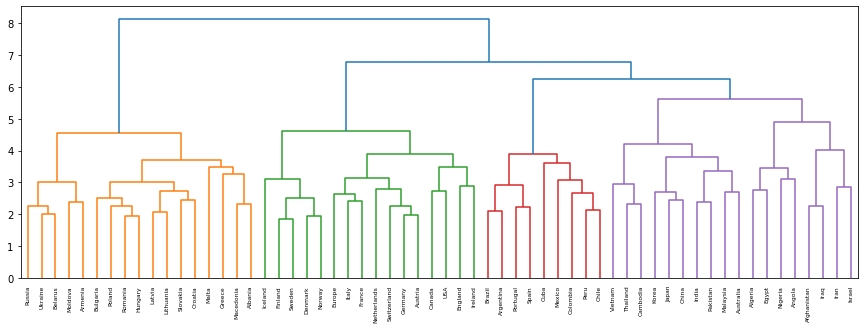

In [8]:
plt.figure(figsize=(15, 5))
dendrogram(model, labels=countries)
plt.show()

# 69

In [9]:
tsne = TSNE()
result = tsne.fit_transform(countries_vec)

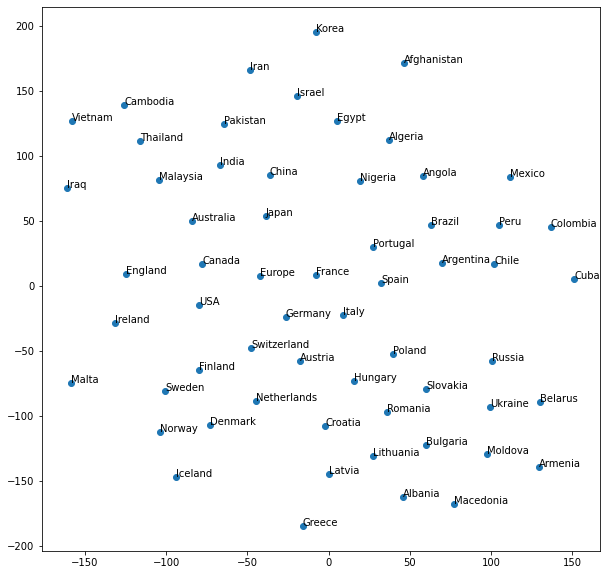

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1])
for (x, y), name in zip(result, countries):
    plt.annotate(name, (x, y))